# DATA 200 Final Project: Contraception

*Team Members: Isabel Serrano, Edie Espejo, and Asem Berkalieva*

This notebook contains all of the code for conducting our final project. It is organized into the following sections:

1. Exploratory Data Analysis (EDA)
2. Feature Engineering and Data Cleaning
3. Modeling (Logistic Regression and Random Forests)
    - 3a. Contraception use by no use, short term, long term 
    - 3b. Contraception use by yes vs. no  
    - 3c. Contraception use by short term vs. long term (for those on contraception)
4. Assessing Precision and Recall

In [5]:
# import libraries
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import re

colours_cafe = np.array(['#6B3231', '#DB565D', '#FACCAD', '#FF8A40'])
colours_cafe = sns.set_palette(sns.color_palette(colours_cafe))

In [8]:
# read in raw dataset
#contra = pd.read_csv('../../1-data/contraceptive_for_students.csv')
contra = pd.read_csv("/Users/isabelserrano/Desktop/contraception-master/1-data/contraceptive_for_students.csv")
this_dic = {1:0, 3:1, 2:2}
contra['contraceptive'] = contra['contraceptive'].map(this_dic)

In [9]:
# explore
contra.head(5)

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
0,24,2,3,3,1,1,2,3,0,0
1,45,1,3,10,1,1,3,4,0,0
2,43,2,3,7,1,1,3,4,0,0
3,42,3,2,9,1,1,3,3,0,0
4,36,3,3,8,1,1,3,2,0,0


In [20]:
# split into train and test
contra_train, contra_test = train_test_split(contra, test_size=0.25, random_state=100)

## 1. Exploratory Data Analysis

### 1a. Subset Verification
The hypothesis test below is verifying the representativeness of number of children within this subset of the full national survey. We are testing whether or not the mean "fertility rate" which is the number of children a woman has in her lifetime is truly 3.3 or not according to a Wilcoxon Signed-Rank test. The resulting p-value of 0.0004 provides evidence that our subset (the initial dataset without any cleaning) does not have a fertility rate that matches the stated average from the pamphlet.

In [21]:
np.mean(contra['num_child']), np.std(contra['num_child'])

(3.2613713509843856, 2.3577481331234518)

In [22]:
from scipy.stats import wilcoxon
wilcoxon(contra['num_child'] - 3.3)

WilcoxonResult(statistic=485783.0, pvalue=0.0004621540880216536)

### 1b. Summary Statistics

In [23]:
contra_train.apply([np.mean, np.median])

,wife_age,wife_education,husband_education,num_child,wife_religion,wife_work,husband_occupation,standard_living,media_exposure,contraceptive
mean,32.365942,2.942029,3.415761,3.218297,0.852355,0.749094,2.143116,3.130435,0.078804,0.80163
median,31.000000,3.000000,4.000000,3.000000,1.000000,1.000000,2.000000,3.000000,0.000000,1.00000


### 1c. Distribution of number of children per age group
Seven equally-spaced age groups were created based on the standardized wife age values. The barplots show that the relative frequencies between age groups differ. In the younger age groups, no contraception and short-term contraception are used at similar rates. In older age groups, more mass is distributed to the "None" contraception bar. Notably, the middle age group (-0.0199, 0.489] shows a relatively uniform spread between all three contraceptive options.

In [24]:
contra_train['age_bin'] = pd.cut(contra_train.wife_age, bins=7)
age_contra = contra_train.groupby(['age_bin', 'contraceptive'], as_index=False).size().to_frame().reset_index()
age_contra = age_contra.rename({0:'count'}, axis=1)

num_in_bins = contra_train.groupby('age_bin', as_index=False).size()
age_contra['total'] = np.array(np.repeat(num_in_bins, len(contra_train['contraceptive'].unique())))
age_contra['freq'] = age_contra['count'] / age_contra['total']

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


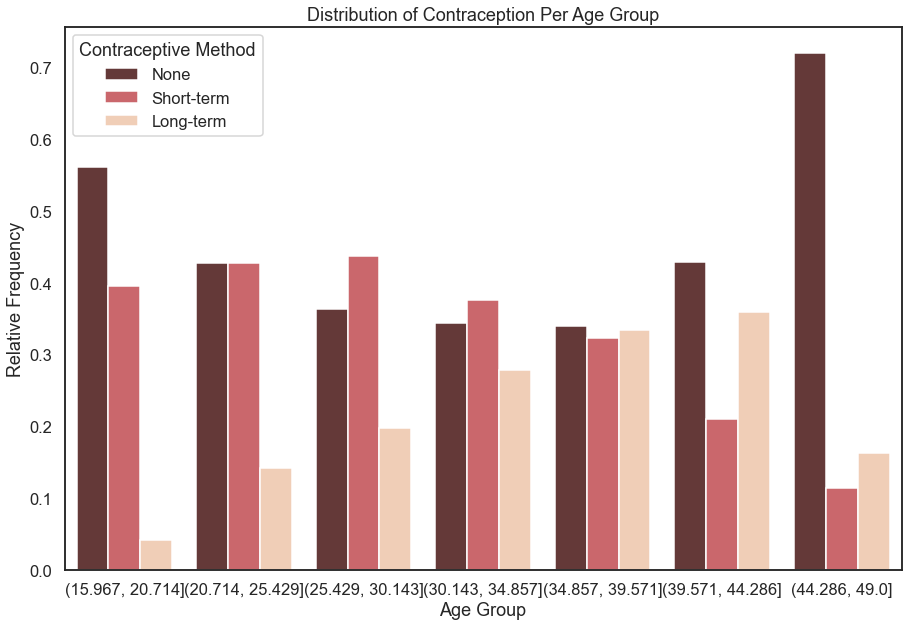

In [17]:
plt.figure(figsize=(15,10))
age_contra['contra_description'] = age_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
ax = sns.barplot(x='age_bin',
            y='freq',
            hue='contra_description',
            data=age_contra)


ax.set(ylabel='Relative Frequency', xlabel='Age Group', title='Distribution of Contraception Per Age Group')
ax.legend(title='Contraceptive Method');

### 1d. Number of kids versus age
Below, we plot the distribution of number of children within each wife age group. Recall that the age groups are standardized and the minimum wife age in our dataset is 20 years. Clearly, women in older age groups have a larger range and more children on average. The $R^2$ value between number of children and wife age is approximately 0.268. The relationship here does not seem to be linear as expected due in part to natural limitations of fertility.

In [19]:
contra_train2 = pd.read_csv('../../1-data/train.csv')

plt.figure(figsize=(15,10))
ax = sns.boxplot(x=round(contra_train2['wife_age'], 3),
                 y='num_child',
                 data=contra_train2,
                 palette=['#6B3231', '#DB565D', '#FACCAD', '#FF8A40'])

ax.set(ylabel='Number of Children',
       xlabel='Wife Age',
       title='Distribution of Children By Wife Age')

ax.set_xticklabels(
    ax.get_xticklabels(), 
    rotation=45, 
    horizontalalignment='right',
    fontweight='light');

FileNotFoundError: [Errno 2] File b'../../1-data/train.csv' does not exist: b'../../1-data/train.csv'

In [11]:
r_sq = np.corrcoef(x=contra_train2['wife_age'], y=contra_train2['num_child'])[0,1]**2
print('The R^2 value between number of children and wife age is ' + str(r_sq) + '.')

The R^2 value between number of children and wife age is 0.2686244303731018.


### 1e. Calculating the Percent of Women Under the Age of 20 
In order to include number of children per year as a feature, we need to filter out women under the age of 20 as we do not have summary statistics concerning their estimated year of marriage. As our calculations show, women under the age of 20 compose 2% of our sample and do not change the median age in our sampled population. Thus, removing these records from our data will cause minimal changes in our sample characteristics.  

In [48]:
perc_of_women_under_20 = contra_train[contra_train["wife_age"] < 20].shape[0]/ contra_train.shape[0]
women_over_20 = contra_train[contra_train["wife_age"] > 20]
median_age_wo_under_20 = women_over_20["wife_age"].median()

print("% of women under 20:", perc_of_women_under_20)
print("Median Age without women under 20:", median_age_wo_under_20)

% of women under 20: 0.02355072463768116
Median Age without women under 20: 32.0


### 1f. Examining the Distribution of Contraception Use Across Women 
Additionally, we examined the distribution of contraception use among women as a skewness in our outcome variable may heavily impact our predictive ability. As noticed below, there is generally an uneven distribution among contraceptive types used. When we binarize use of contraceptive we lessen this uneven distribution of data for our outcome variable. These figures influenced our decision to compare predictive ability of the multinomial regression and the two-step binarized models. 


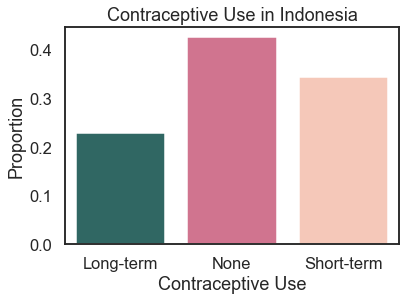

In [52]:
contra_dist = contra_train.copy()

contra_dist.replace({"contraceptive": {0: "None", 1:"Short-term", 2:"Long-term"}}, inplace = True)

contra = sns.barplot(x = (contra_dist.groupby('contraceptive')["contraceptive"].count()/contra_dist.shape[0]).index, \
            y = (contra_dist.groupby('contraceptive')["contraceptive"].count()/contra_dist.shape[0]).values,  \
           palette=['#27706B', '#DF6589', '#FFC3AF' ])
plt.title("Contraceptive Use in Indonesia")
plt.xlabel("Contraceptive Use")
plt.ylabel("Proportion");

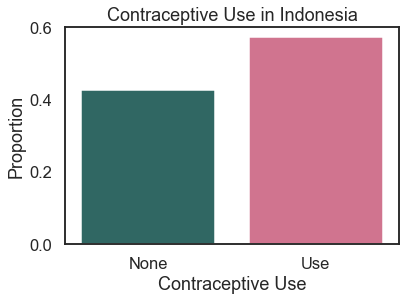

In [53]:
contra_binary = contra_train.copy()
contra_binary.replace({"contraceptive": {0: "None", 1:"Use", 2:"Use"}}, inplace = True)

contra_binary.replace({"wife_education": {1: "Incomp Prim", 2:"Incomp Prim", 3:"Comp Prim", 4:"Comp Prim"}}, \
                    inplace = True)

contra_binary.replace({"standard_living": {1: "Low", 2:"Middle", 3:"Middle", 4:"High"}}, \
                    inplace = True)

use = sns.barplot(x = (contra_binary.groupby('contraceptive')["contraceptive"].count()/contra_binary.shape[0]).index, \
            y = (contra_binary.groupby('contraceptive')["contraceptive"].count()/contra_binary.shape[0]).values,  \
           palette=['#27706B', '#DF6589'])
plt.title("Contraceptive Use in Indonesia")
plt.xlabel("Contraceptive Use")
plt.ylabel("Proportion");

### 1g. Examining the Distribution of Standard of Living and Education
As above, we wanted to determine if there was an uneven representation of women in our data subset. Noticeably, our data contains uneven sampling largely containing women from higher standards of living and those that have completed a primary level of education. 

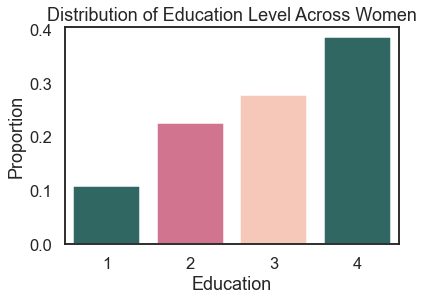

In [56]:
edu = sns.barplot(x = (contra_dist.groupby('wife_education')["wife_education"].count()/contra_dist.shape[0]).index, \
            y = (contra_dist.groupby('wife_education')["wife_education"].count()/contra_dist.shape[0]).values,  \
           palette=['#27706B', '#DF6589', '#FFC3AF'])
plt.title("Distribution of Education Level Across Women")
plt.xlabel("Education")
plt.ylabel("Proportion");

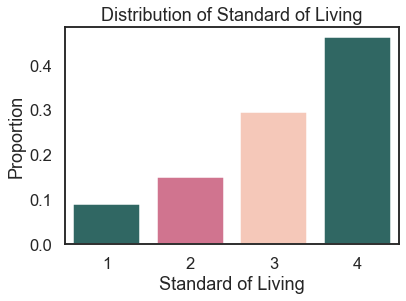

In [66]:
stand_living = sns.barplot(x = (contra_dist.groupby('standard_living')["standard_living"].count()/contra_dist.shape[0]).index, \
            y = (contra_dist.groupby('standard_living')["standard_living"].count()/contra_dist.shape[0]).values,  \
           palette=['#27706B', '#DF6589', '#FFC3AF', '#27706B'])
plt.title("Distribution of Standard of Living")
plt.xlabel("Standard of Living")
plt.ylabel("Proportion");

In [64]:
(contra_dist.groupby('standard_living')["standard_living"].count()/contra_dist.shape[0]).index

Int64Index([1, 2, 3, 4], dtype='int64', name='standard_living')

## 2. Feature Engineering and Data Cleaning

### 2a. Creating Education Gap
The distributions of contraceptive method are not uniform per education gap group. When husbands are more educated than their wives, it seems that the "None" group is more frequent than the two contraceptive groups. When the husbands and wives are equally educated, the distribution of preferences is more uniform, however there are still more subjects within the "None" group than the other two. When the wife is more educated, short-term contraceptives are most popular.

In [27]:
contra_tmp = contra_train.copy()

In [28]:
contra_tmp['education_gap'] = contra_tmp['husband_education'] - contra_tmp['wife_education']
gap_intervals = [-3, 0, 1, 4]
contra_tmp['education_gap_categorical'] = pd.cut(contra_tmp.education_gap, bins=gap_intervals, labels=[-1, 0, 1], right=False)
   
contra_tmp.education_gap.value_counts().to_frame() / contra_tmp.shape[0]

,education_gap
0,0.544384
1,0.283514
2,0.103261
-1,0.045290
3,0.015399
-2,0.007246
-3,0.000906


In [29]:
edugap_contra = contra_tmp.groupby(['education_gap_categorical', 'contraceptive'], as_index=False).size().to_frame().reset_index()
edugap_contra = edugap_contra.rename({0:'count'}, axis=1)
num_in_bins = edugap_contra.groupby('education_gap_categorical', as_index=False).size()

edugap_contra['total'] = np.array(np.repeat(num_in_bins, len(contra_tmp['contraceptive'].unique())))
edugap_contra['freq'] = edugap_contra['count'] / edugap_contra['total']

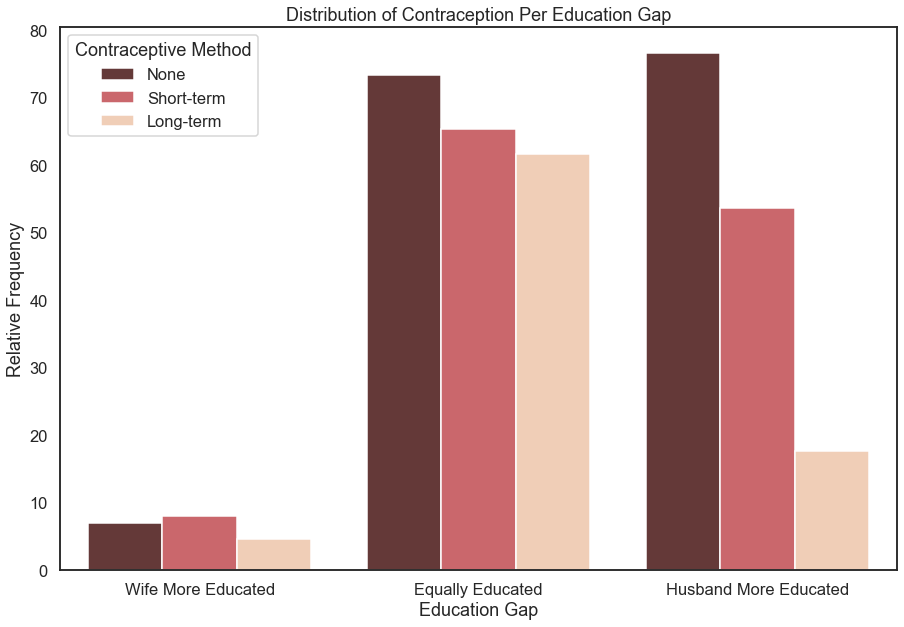

In [30]:
plt.figure(figsize=(15,10))
edugap_contra['contra_description'] = edugap_contra['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'})
edugap_contra['education_gap_categorical'] = edugap_contra['education_gap_categorical'].map({-1:'Wife More Educated', 0:'Equally Educated', 1:'Husband More Educated'})

ax = sns.barplot(x='education_gap_categorical',
            y='freq',
            hue='contra_description',
            data=edugap_contra)


ax.set(ylabel='Relative Frequency', xlabel='Education Gap', title='Distribution of Contraception Per Education Gap')
ax.legend(title='Contraceptive Method');

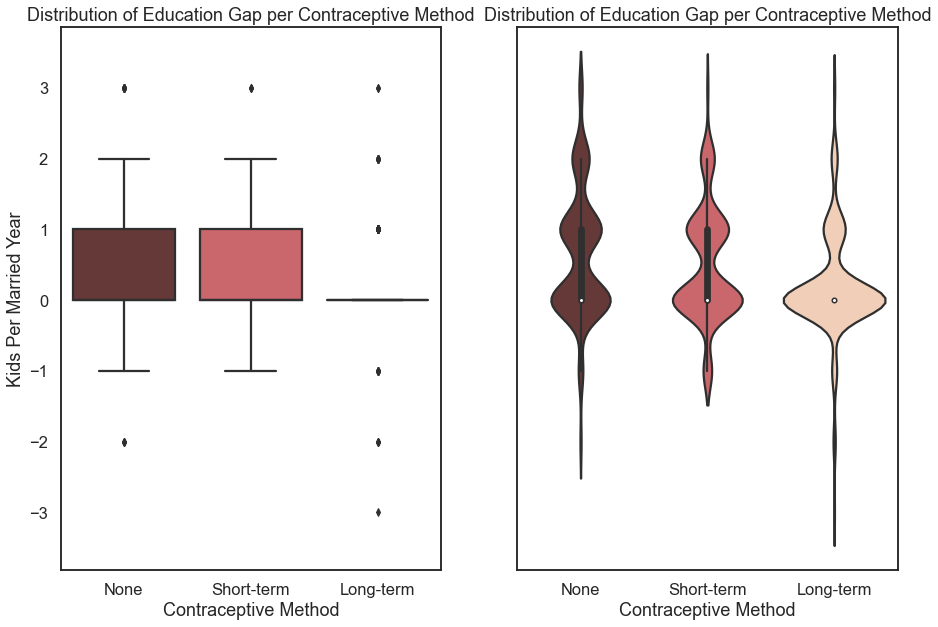

In [31]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,10))

sns.boxplot(x=contra_tmp['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}),
            y='education_gap',
            data=contra_tmp,
            order=['None', 'Short-term', 'Long-term'],
            ax=ax[0])

ax[0].set(ylabel='Kids Per Married Year',
          xlabel='Contraceptive Method',
          title='Distribution of Education Gap per Contraceptive Method');

sns.violinplot(x=contra_tmp['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}),
               y='education_gap',
               data=contra_tmp,
               order=['None', 'Short-term', 'Long-term'],
               ax = ax[1])

ax[1].set(ylabel='',
       xlabel='Contraceptive Method',
       title='Distribution of Education Gap per Contraceptive Method')


plt.show()

### 2b. Creating Kids Per Married Year
We are interested in the relationship between our engineered feature, KPMY, and the existing covariates of wife age and number of children. We see that the scatteplot between wife age and number of children shows patterns that can be explained by the feature's calculation. That is, there is a minimum estimated number of married years per age group, therefore KPMY has a linear offset for each level of number of children. There are also outliers where some women had many children very quickly with a high KPMY. The $R^2$ value between these two variables is 0.060 which provides evidence for a nonlinear relationship.

In [17]:
# the following function cleans the lower bound and upper bound of the intervals into their own columns.
def cleanIntervals(age_intervals):
    '''
    Input:
        age_intervals: Array of intervals
    Output:
        lows: An array of lower bounds
        highs: An array of upper bounds
    '''
    
    lows  = []
    highs = []
    
    for ix in range(len(age_intervals)):
        lo_hi = [re.sub('\(|\]', '', k) for k in age_intervals[ix].split(',')]
        lows.append(lo_hi[0])
        highs.append(lo_hi[1])
        
    return(np.array(lows),
           np.array(highs))

In [18]:
contra_tmp = contra_tmp[contra_tmp.wife_age > 20]
contra_tmp = contra_tmp.reset_index(drop=True)

### set age intervals to define median age married
age_intervals = pd.IntervalIndex.from_tuples([(20, 24), (24, 29), (29, 34), (34,39), (39,44), (44, 49)])
age_interval_df = pd.DataFrame(age_intervals)
age_interval_df['median_marriage_age'] = [19.6, 18.1, 17.6, 16.8, 16.4, 16.5]
age_interval_df = age_interval_df.rename({0:'age_bin'}, axis=1)
age_interval_df['age_bin'] = age_interval_df['age_bin'].astype(str)
age_interval_df['age_bin_low'], age_interval_df['age_bin_high'] = cleanIntervals(age_interval_df.age_bin)
contra_tmp['age_bin'] = pd.cut(contra_tmp.wife_age, bins=age_intervals)

### fill the NA's
contra_tmp['age_bin'] = contra_tmp['age_bin'].cat.add_categories('None')
contra_tmp['age_bin'] = contra_tmp['age_bin'].fillna('None')
contra_tmp['age_bin'] = contra_tmp['age_bin'].astype(str)

contra_tmp['age_bin_low'], contra_tmp['age_bin_high'] = cleanIntervals(contra_tmp.age_bin)
contra_tmp = contra_tmp.merge(age_interval_df)

### create est_years_married: wife's age minus median marriage age for age group
contra_tmp['est_years_married'] = contra_tmp['wife_age'] - contra_tmp['median_marriage_age']

### create kids_per_year: amount of kids divided by number of est years married
contra_tmp['kids_per_year'] = contra_tmp['num_child'] / contra_tmp['est_years_married']

In [19]:
np.mean(contra_tmp['kids_per_year'])

0.27422882816512245

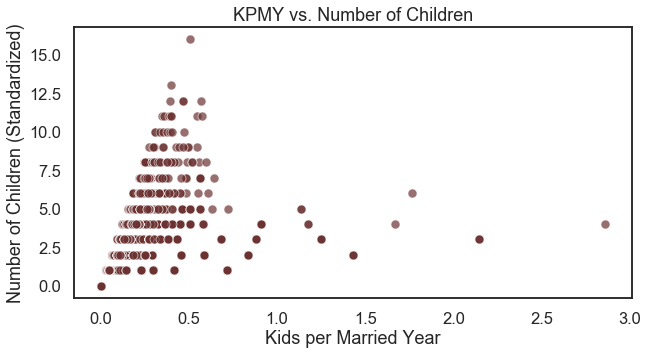

In [20]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='kids_per_year',
                     y='num_child',
                     data=contra_tmp,
                     alpha=0.7)

ax.set(ylabel='Number of Children (Standardized)',
       xlabel='Kids per Married Year',
       title='KPMY vs. Number of Children');

In [21]:
r_sq = np.corrcoef(x=contra_tmp['kids_per_year'], y=contra_tmp['num_child'])[0,1]**2
print('The R^2 value between KPMY and number of children is ' + str(r_sq) + '.')

The R^2 value between KPMY and number of children is 0.05866323547070084.


The plot below reflects the relationship between KPMY and wife age. The relationship between these two variables exhibits qualities of an exponential decay curve shifted across multiple starting points. The $R^2$ value between these two variables is 0.157 which provides evidence for a nonlinear relationship.

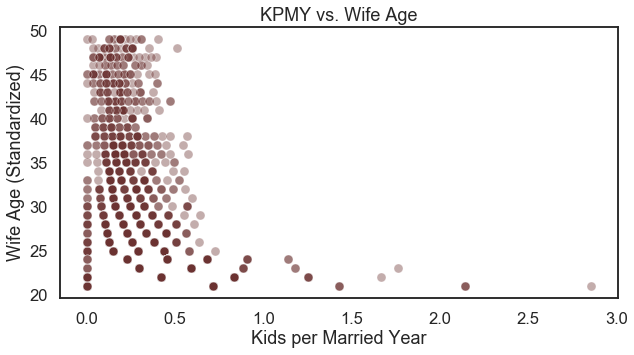

In [22]:
plt.figure(figsize=(10,5))
ax = sns.scatterplot(x='kids_per_year',
                     y='wife_age',
                     data=contra_tmp,
                     alpha=0.4)

ax.set(ylabel='Wife Age (Standardized)',
       xlabel='Kids per Married Year',
       title='KPMY vs. Wife Age');

Since we are using KPMY as a covariate in multiclass prediction, we check below if there are significant differences in KPMY values across the three classes: no contraception, short-term, and long-term. We will use a Kruskal-Wallis test to determine to test the hypothesis of whether or not the three groups share the same KPMY distribution. The resulting p-value of 2.772e-25 leads us to conclude that there are distributional differences of KPMY between the three classes.

In [23]:
contra_tmp['contraceptive'].value_counts() / contra_tmp.shape[0]

0    0.420455
1    0.342803
2    0.236742
Name: contraceptive, dtype: float64

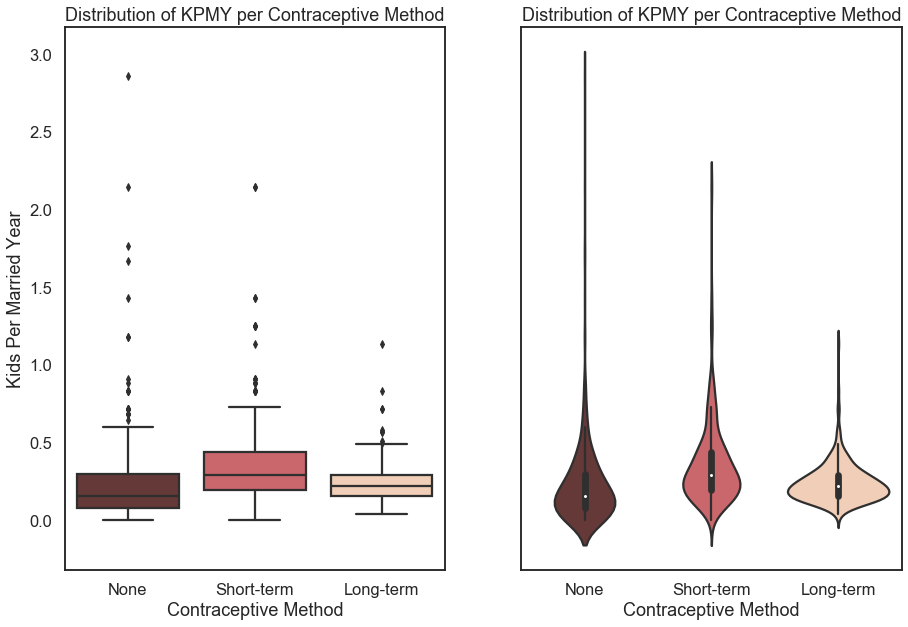

In [24]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,10))

sns.boxplot(x=contra_tmp['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}),
            y='kids_per_year',
            data=contra_tmp,
            order=['None', 'Short-term', 'Long-term'],
            ax = ax[0])

ax[0].set(ylabel='Kids Per Married Year',
          xlabel='Contraceptive Method',
          title='Distribution of KPMY per Contraceptive Method');

sns.violinplot(x=contra_tmp['contraceptive'].map({0:'None', 1:'Short-term', 2:'Long-term'}),
               y='kids_per_year',
               data=contra_tmp,
               order=['None', 'Short-term', 'Long-term'],
               ax = ax[1])

ax[1].set(ylabel='',
       xlabel='Contraceptive Method',
       title='Distribution of KPMY per Contraceptive Method')


plt.show()

In [25]:
from scipy import stats
stats.kruskal(contra_tmp['kids_per_year'][contra_tmp['contraceptive'] == 0], 
              contra_tmp['kids_per_year'][contra_tmp['contraceptive'] == 1],
              contra_tmp['kids_per_year'][contra_tmp['contraceptive'] == 2])

KruskalResult(statistic=113.12097832014258, pvalue=2.7295538332042766e-25)

Since we are also interested in the binary prediction between women who use and do not use contraception in our dataset, we will test the hypothesis of whether KPMY is distributed the same between these binary groups. We will opt for a Mann-Whitney U test to circumvent distributional assumptions. We conclude that there are distributional differences for KPMY between the no contraception and the contraception groups (p-value=1.123e-20).

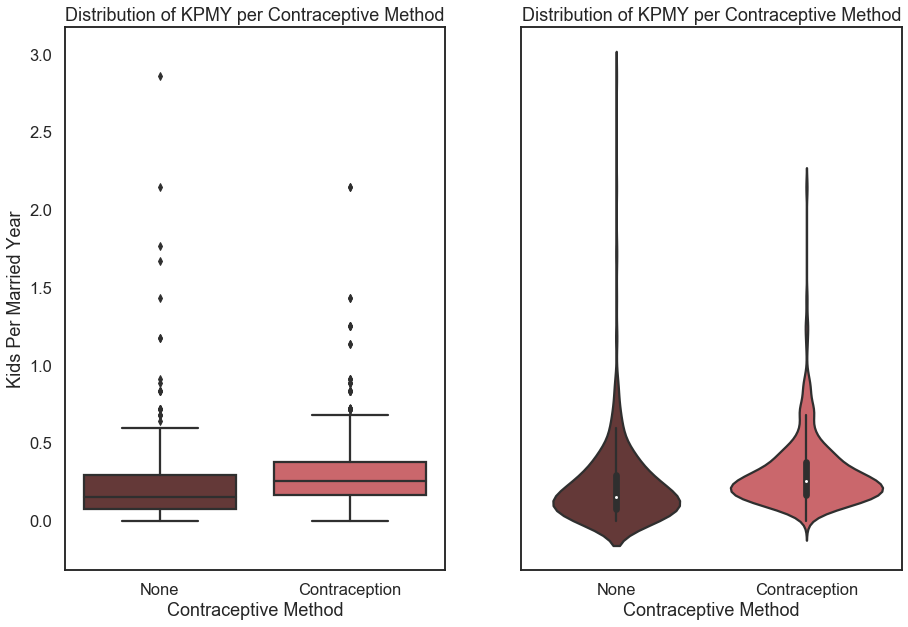

In [26]:
fig, ax = plt.subplots(1,2, sharey=True, figsize=(15,10))

sns.boxplot(x=contra_tmp['contraceptive'].map({0:'None', 1:'Contraception', 2:'Contraception'}),
            y='kids_per_year',
            data=contra_tmp,
            ax = ax[0])

ax[0].set(ylabel='Kids Per Married Year',
          xlabel='Contraceptive Method',
          title='Distribution of KPMY per Contraceptive Method');

sns.violinplot(x=contra_tmp['contraceptive'].map({0:'None', 1:'Contraception', 2:'Contraception'}),
               y='kids_per_year',
               data=contra_tmp,
               ax = ax[1])

ax[1].set(ylabel='',
       xlabel='Contraceptive Method',
       title='Distribution of KPMY per Contraceptive Method')


plt.show()

In [34]:
from scipy import stats
stats.mannwhitneyu(x=contra_tmp['kids_per_year'][contra_tmp['contraceptive'] == 0],
                   y=contra_tmp['kids_per_year'][contra_tmp['contraceptive'].isin([1,2])])

KeyError: 'kids_per_year'

### 2x. Function
We have written a wrapper function that preprocesses the raw data and outputs a train and test dataset that can be fed into the modeling code. We will use the following function without our preprocessing function:

The following is the complete processing function that takes in the raw contraception dataset and output the train and test data:

In [32]:
def preprocess(data):
    
    # 1. define Kids Per Married Year:
    
    ### drop those under 20
    data = data[data.wife_age > 20]
    data = data.reset_index(drop=True)
    
    ### set age intervals to define median age married
    age_intervals = pd.IntervalIndex.from_tuples([(20, 24), (24, 29), (29, 34), (34,39), (39,44), (44, 49)])
    age_interval_df = pd.DataFrame(age_intervals)
    age_interval_df['median_marriage_age'] = [19.6, 18.1, 17.6, 16.8, 16.4, 16.5]
    age_interval_df = age_interval_df.rename({0:'age_bin'}, axis=1)
    age_interval_df['age_bin'] = age_interval_df['age_bin'].astype(str)
    age_interval_df['age_bin_low'], age_interval_df['age_bin_high'] = cleanIntervals(age_interval_df.age_bin)
    data['age_bin'] = pd.cut(data.wife_age, bins=age_intervals)

    ### fill the NA's
    data['age_bin'] = data['age_bin'].cat.add_categories('None')
    data['age_bin'] = data['age_bin'].fillna('None')
    data['age_bin'] = data['age_bin'].astype(str)
    
    data['age_bin_low'], data['age_bin_high'] = cleanIntervals(data.age_bin)
    data = data.merge(age_interval_df)
    
    ### create est_years_married: wife's age minus median marriage age for age group
    data['est_years_married'] = data['wife_age'] - data['median_marriage_age']
    
    ### create kids_per_year: amount of kids divided by number of est years married
    data['kids_per_year'] = data['num_child'] / data['est_years_married']
    
    ### drop unnecessary age_bin feature
    data.drop(['age_bin'], axis=1, inplace=True)
    
    # 2. Education gap
    data['education_gap'] = data['husband_education'] - data['wife_education']
    gap_intervals = [-3, 0, 1, 4]
    data['education_gap_categorical'] = pd.cut(data.education_gap, bins=gap_intervals, labels=[-1, 0, 1], right=False)
    
    # 3. Contraceptive Use
    this_dic = {0:0, 1:1, 2:1}
    data['contraceptive_use'] = data['contraceptive'].map(this_dic)
    
    # 4. Adjusted Standard of Living
    
    ### combine middle-low and middle-high into single category
    this_dic = {1: 1, 2:2, 3:2, 4:3}
    data['standard_living'] = data['standard_living'].map(this_dic)
    
    # 5. Adjusted Education Level
    
    ### separate wives' education level into 0 for not having completed primary school and 1 for completing primary school
    this_dic = {1:0, 2:0, 3:1, 4:1}
    data['wife_education'] = data['wife_education'].map(this_dic)
    
    # 6. One-hot Encoding Categorical Variables
    data = pd.get_dummies(data,
                        columns=['wife_education', 'husband_education', 'wife_religion',
                                 'wife_work', 'husband_occupation', 'standard_living',
                                 'media_exposure', 'education_gap_categorical'],
                        drop_first=True)
    
    # 7. Scaling Continuous Variables
    continuous_vars = ['wife_age', 'num_child', 'kids_per_year', 'est_years_married']
    standardized_vars = pd.DataFrame(StandardScaler().fit_transform(data[continuous_vars]), columns=continuous_vars)
    
    ### drop original, non-scaled variables
    data.drop(continuous_vars, axis=1, inplace=True)
    data = data.join(standardized_vars)
    
    # 8. return cleaned dataset
    return data

In [33]:
# apply function to the two datasets
contra_train_clean = preprocess(contra_train)
contra_test_clean = preprocess(contra_test)

NameError: name 'cleanIntervals' is not defined

In [30]:
# examine outputs
[contra.shape, contra_train_clean.shape, contra_test_clean.shape]

[(1473, 10), (1056, 24), (353, 24)]

## 3. Modeling

We will predict and compare three outcomes of interest:

- Contraceptive method of (1) no use, (2) short term, (3) long term
- Contraceptive method of (1) no use vs. (2) use?
- Contraceptive method of (1) short-term vs. (2) long-term for those on contraception

Which of the three above has a better prediction accuracy? What are the pros and cons of each? 

Additionally, by running logistic regression and Random Forests on each of the above, we hope to assess which model performs better and why.

### 3a. Predicting Contraceptive: No Use, Short Term, Long Term
#### i. Feature Selection and Data Preparation
Our first set of models will work on predicting all three outcomes. We will start by running our multinomial logistic regression model with all existing features in the dataset to evaluate initial performance. Afterwards, we will utilize a leave-one-out approach to determine which features help vs. hurt accuracy in order to pick the optimal combination.

Here is the ultimate set of features that we drop (see Part iii on details).

In [31]:
# training data
# remove the first 2 because they are the response
# remove age_bin because they were used for another variable
# remove education_gap because it was coded into a categorical variable
X_train = contra_train_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                             'education_gap', 'wife_age', 'num_child'], axis = 1)
Y_train = contra_train_clean['contraceptive']

# test data
X_test = contra_test_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                           'education_gap', 'wife_age', 'num_child'], axis = 1)
Y_test = contra_test_clean['contraceptive']

#### ii. Multinomial Logistic Regression

Here is the multinomial logistic regression without CV.

In [32]:
from sklearn.linear_model import LogisticRegression

# fit multinomial model
multinomial_logit = LogisticRegression(multi_class='multinomial', solver='newton-cg')
multinomial_logit.fit(X = X_train, y = Y_train)

# obtain accuracies (train and CV)
train_accuracy_lr = multinomial_logit.score(X = X_train, y = Y_train)
test_accuracy_lr  = multinomial_logit.score(X = X_test, y = Y_test)

# print accuracy
[train_accuracy_lr, test_accuracy_lr]

[0.5606060606060606, 0.46175637393767704]

In [33]:
coef_df = pd.DataFrame(multinomial_logit.coef_).T
coef_df = coef_df.apply(np.exp)
coef_df.insert(0, 'covariate', X_train.columns)
coef_df = coef_df.sort_values(by=[0,1,2], ascending=False)
coef_df.to_csv('../../3-output/multinomial-logit-coef.csv')
coef_df

,covariate,0,1,2
0,median_marriage_age,2.091204,0.666310,0.717674
16,est_years_married,2.056530,0.548533,0.886466
14,education_gap_categorical_1,1.962771,0.964749,0.528100
13,education_gap_categorical_0,1.429635,0.752391,0.929675
5,wife_religion_1,1.414735,0.980726,0.720737
12,media_exposure_1,1.370073,0.749246,0.974164
7,husband_occupation_2,1.185907,1.421175,0.593337
8,husband_occupation_3,0.975531,1.435600,0.714045
6,wife_work_1,0.919098,1.081199,1.006311
2,husband_education_2,0.841769,2.706726,0.438897


Here is the multinomial logistic regression with CV=10.

In [34]:
from sklearn.linear_model import LogisticRegressionCV

# fit multinomial CV model
multinomial_logit_cv = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='newton-cg')
multinomial_logit_cv.fit(X = X_train, y = Y_train)

# obtain CV accuracies
train_accuracy_cv = multinomial_logit_cv.score(X = X_train, y = Y_train)
test_accuracy_cv  = multinomial_logit_cv.score(X = X_test, y = Y_test)

# print
[train_accuracy_cv, test_accuracy_cv]

[0.5643939393939394, 0.45609065155807366]

In [35]:
coef_df = pd.DataFrame(multinomial_logit_cv.coef_).T
coef_df = coef_df.apply(np.exp)
coef_df.insert(0, 'covariate', X_train.columns)
coef_df = coef_df.sort_values(by=[0,1,2], ascending=False)
coef_df.to_csv('../../3-output/multinomial-logit-cv-coef.csv')
coef_df

,covariate,0,1,2
0,median_marriage_age,1.468973,0.833437,0.816796
16,est_years_married,1.456477,0.689613,0.995613
5,wife_religion_1,1.254527,0.971452,0.820538
14,education_gap_categorical_1,1.248821,1.097800,0.729418
12,media_exposure_1,1.243990,0.845580,0.950667
7,husband_occupation_2,1.136115,1.199838,0.733593
2,husband_education_2,1.116870,1.107355,0.808557
13,education_gap_categorical_0,0.983187,0.871383,1.167226
9,husband_occupation_4,0.979854,0.986620,1.034401
8,husband_occupation_3,0.975852,1.251364,0.818903


#### iii. Visualize Feature Selection vs. CV Error
To select features, we began with including all features in the model and removing, one by one, those that decreased training error. We have written a function that evaluates this for the first round (first feature removal) and subsequently, we plot this to more easily visualize the effect of feature removal.

In [36]:
# modified df
contra_df = contra_train_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', \
                               'age_bin_high', 'education_gap'], axis = 1)

# features we will remove one by one
quantitative_features = ['median_marriage_age', 'wife_education_1', 'wife_religion_1', \
                         'wife_work_1', 'media_exposure_1', 'wife_age', 'num_child', \
                         'kids_per_year', 'est_years_married']

# to track accuracy for features
accuracy_train = {}
accuracy_cv_train = {}

# loop through feature removal
for i in range(len(quantitative_features)):

    # The name we are giving to the ith model
    name = quantitative_features[i]

    # subset dataframe
    X_train_i = contra_df.drop(quantitative_features[i], axis = 1)
    Y_train_i = contra_train_clean['contraceptive']

    # initialize models
    model = LogisticRegression(multi_class='multinomial', solver='newton-cg')
    model_cv = LogisticRegressionCV(cv=10, multi_class='multinomial', solver='newton-cg')

    # fit models
    model.fit(X = X_train_i, y = Y_train_i)
    model_cv.fit(X = X_train_i, y = Y_train_i)
    train_model = model.score(X = X_train_i, y = Y_train_i)
    train_model_cv = model_cv.score(X = X_train_i, y = Y_train_i)

    # Saving the ith model
    accuracy_train[name] = train_model
    accuracy_cv_train[name] = train_model_cv

In [37]:
def visualize_errors(accuracy_train, accuracy_cv):
    
    # prepare train df for plotting
    accuracy_train_df = pd.DataFrame(accuracy_train.items(), columns = ['feature','accuracy'])
    accuracy_train_df['type'] = 'train'

    # prepare cv df for plotting
    accuracy_cv_df = pd.DataFrame(accuracy_cv.items(), columns = ['feature','accuracy'])
    accuracy_cv_df['type'] = 'cv'

    # combine datasets
    accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

    # generate plot
    plt.figure(figsize=(10,8))
    ax = sns.barplot(x = 'feature', y = 'accuracy', hue = 'type', data = accuracy_df,
                    palette=['#DF6589', '#FFC3AF'])
    ax.set(xlabel='Feature',
           ylabel='Accuracy');
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)
    
    # return plot
    return ax

[Text(0.5, 1.0, 'Multinomial Logistic Regression Model Accuracy Removing Each Feature')]

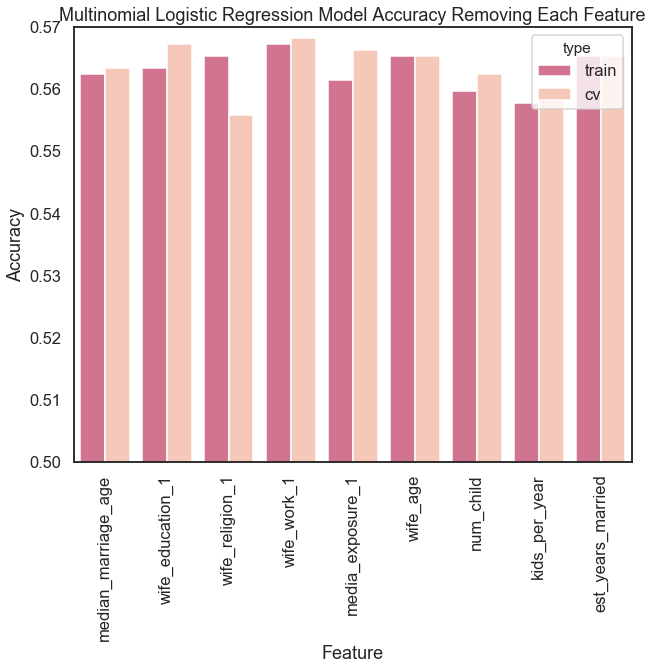

In [38]:
# visualize
ax = visualize_errors(accuracy_train, accuracy_cv_train)
plt.ylim(0.5, 0.57)
ax.set(title = 'Multinomial Logistic Regression Model Accuracy Removing Each Feature')

#### iv. Random Forests

To fit a Random Forests model to the data, we will tune the number of trees using cross-validation, while allowing the Random Forests algorithm to tune the remaining features through its use of bagging. We visualize the training and cross-validated accuracies for a range of number trees to (1) confirm overfitting occurs when fitting on a single training set and (2) select the number of trees we will use.

In [39]:
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

# to track accuracy for features
accuracy_train_rf = {}
accuracy_cv_rf = {}
n_trees = range(5, 30, 5)

# cross validate for n trees
for i in n_trees:
    
    # fit model
    random_forest = ensemble.RandomForestClassifier(n_estimators = i)
    random_forest.fit(X = X_train, y = Y_train)
    
    # obtain accuracy
    accuracy_train_rf[i] = random_forest.score(X = X_train, y = Y_train)
    accuracy_cv_rf[i] = cross_val_score(random_forest, X_train, Y_train, cv = 5).mean()

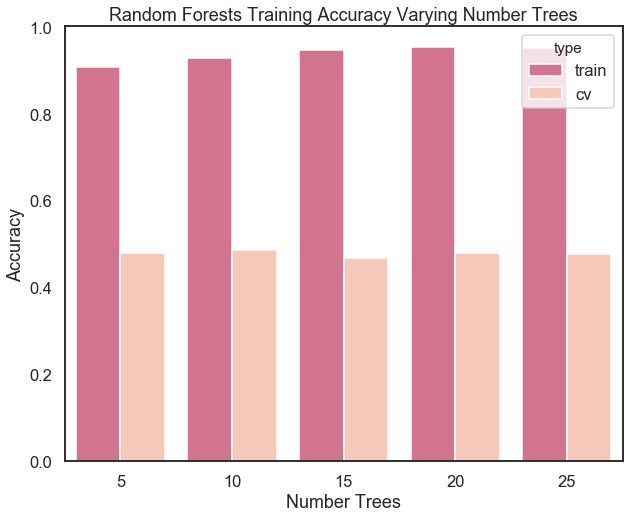

In [40]:
# prepare train df for plotting
accuracy_train_df = pd.DataFrame(accuracy_train_rf.items(), columns = ['n_tree','accuracy'])
accuracy_train_df['type'] = 'train'
accuracy_train_df

# prepare cv df for plotting
accuracy_cv_df = pd.DataFrame(accuracy_cv_rf.items(), columns = ['n_tree','accuracy'])
accuracy_cv_df['type'] = 'cv'

# combine datasets
accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

# generate plot
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'n_tree', y = 'accuracy', hue = 'type', data = accuracy_df,
                palette=['#DF6589', '#FFC3AF'])
ax.set(xlabel='Number Trees',
       ylabel='Accuracy',
       title = 'Random Forests Accuracy by Varying Number Trees: No Use, Short-term, Long-term');

Finally, we fit the final training model with the selected number of trees.

In [41]:
# fit final model with n tree selected
random_forest = ensemble.RandomForestClassifier(n_estimators=25)
random_forest.fit(X = X_train, y = Y_train)

# obtain accuracies
train_accuracy_rf = random_forest.score(X = X_train, y = Y_train)
test_accuracy_rf = random_forest.score(X = X_test, y = Y_test)

# print
[train_accuracy_rf, test_accuracy_rf]

[0.9554924242424242, 0.5269121813031161]

### 3b. Predicting Binary Contraceptive: No vs. Yes

We will repeat the above process on the binary outcomes (starting with use vs. no use).

#### i. Feature Selection and Data Preparation

Here are the features we have selected to use (see Part iii for details).

In [42]:
# training data
X_train_binary = contra_train_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                    'education_gap', 'wife_age'], axis = 1)
Y_train_binary = contra_train_clean['contraceptive_use']

# test data
X_test_binary = contra_test_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                  'education_gap', 'wife_age'], axis = 1)
Y_test_binary = contra_test_clean['contraceptive_use']

#### ii. Binary Logistic Regression

Here is the binary logistic regression without CV.

In [43]:
# fit binomial logistic regression model
binary_logit = LogisticRegression(solver = 'newton-cg')
binary_logit.fit(X = X_train_binary, y = Y_train_binary)

# obtain accuracies
train_accuracy_lr_binary = binary_logit.score(X = X_train_binary, y = Y_train_binary)
test_accuracy_lr_binary  = binary_logit.score(X = X_test_binary, y = Y_test_binary)

# print
[train_accuracy_lr_binary, test_accuracy_lr_binary]

[0.7111742424242424, 0.6770538243626062]

In [44]:
coef_df = pd.DataFrame(np.exp(binary_logit.coef_)).T
coef_df.insert(0, 'covariate', X_train_binary.columns)
coef_df = coef_df.sort_values(by=0, ascending=False)
coef_df.to_csv('../../3-output/binary-logit-coef.csv')
coef_df

,covariate,0
4,husband_education_4,2.634987
11,standard_living_3,2.198738
3,husband_education_3,2.166172
15,num_child,1.845273
1,wife_education_1,1.708828
10,standard_living_2,1.563410
16,kids_per_year,1.377807
2,husband_education_2,1.230336
9,husband_occupation_4,1.226588
6,wife_work_1,1.099829


In [45]:
# fit CV binomial model
binary_logit_cv = LogisticRegressionCV(cv = 10, solver = 'newton-cg')
binary_logit_cv.fit(X = X_train_binary, y = Y_train_binary)

# obtain accuracies
train_accuracy_cv_binary = binary_logit_cv.score(X = X_train_binary, y = Y_train_binary)
test_accuracy_cv_binary  = binary_logit_cv.score(X = X_test_binary, y = Y_test_binary)

# print
[train_accuracy_cv_binary, test_accuracy_cv_binary]

[0.7007575757575758, 0.6685552407932012]

In [46]:
coef_df = pd.DataFrame(np.exp(binary_logit_cv.coef_)).T
coef_df.insert(0, 'covariate', X_train_binary.columns)
coef_df = coef_df.sort_values(by=0, ascending=False)
coef_df.to_csv('../../3-output/binary-logit-cv-coef.csv')
coef_df

,covariate,0
1,wife_education_1,1.706125
15,num_child,1.550442
11,standard_living_3,1.421775
4,husband_education_4,1.374369
16,kids_per_year,1.299535
3,husband_education_3,1.140833
10,standard_living_2,1.089798
13,education_gap_categorical_0,1.060120
8,husband_occupation_3,1.051564
6,wife_work_1,1.046736


#### iii. Visualize Feature Selection vs. CV Error

Here is how dropping features in the first round affected training and CV accuracy.

In [47]:
# modified df
contra_df = contra_train_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', \
                               'age_bin_high', 'education_gap'], axis = 1)

# features we will drop one by one
quantitative_features = ['median_marriage_age', 'wife_education_1', 'wife_religion_1', \
                         'wife_work_1', 'media_exposure_1', 'wife_age', 'num_child', \
                         'kids_per_year', 'est_years_married']

# to track accuracy for features
accuracy_train = {}
accuracy_cv_train = {}

# loop through feature removal
for i in range(len(quantitative_features)):

    # The name we are giving to the ith model
    name = quantitative_features[i]

    # subset dataframe
    X_train_i = contra_df.drop(quantitative_features[i], axis = 1)
    Y_train_i = contra_train_clean['contraceptive_use']

    # initialize models
    model = LogisticRegression(solver = 'newton-cg')
    model_cv = LogisticRegressionCV(cv=10, solver='newton-cg')

    # fit models
    model.fit(X = X_train_i, y = Y_train_i)
    model_cv.fit(X = X_train_i, y = Y_train_i)
    train_model = model.score(X = X_train_i, y = Y_train_i)
    train_model_cv = model_cv.score(X = X_train_i, y = Y_train_i)

    # Saving the ith model
    accuracy_train[name] = train_model
    accuracy_cv_train[name] = train_model_cv

[Text(0.5, 1.0, 'Binary Logistic Regression Model Accuracy Removing Each Feature: Use vs. No Use')]

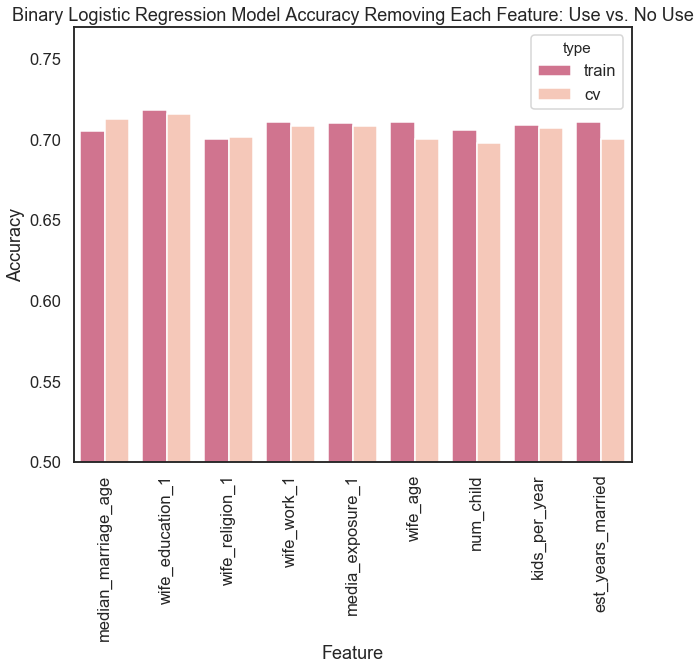

In [48]:
# visualize
ax = visualize_errors(accuracy_train, accuracy_cv_train)
plt.ylim(0.5, 0.77)
ax.set(title = 'Binary Logistic Regression Model Accuracy Removing Each Feature: Use vs. No Use')

#### iv. Random Forests

By cross-validating number of trees, we end up with 25 trees to improve accuracy.

In [49]:
# to track accuracy for features
accuracy_train_rf = {}
accuracy_cv_rf = {}
n_trees = range(5, 30, 5)

# cross validate for n trees
for i in n_trees:
    
    # fit model
    random_forest = ensemble.RandomForestClassifier(n_estimators = i)
    random_forest.fit(X = X_train_binary, y = Y_train_binary)
    
    # obtain accuracy
    accuracy_train_rf[i] = random_forest.score(X = X_train_binary, y = Y_train_binary)
    accuracy_cv_rf[i] = cross_val_score(random_forest, X_train_binary, Y_train_binary, cv = 5).mean()

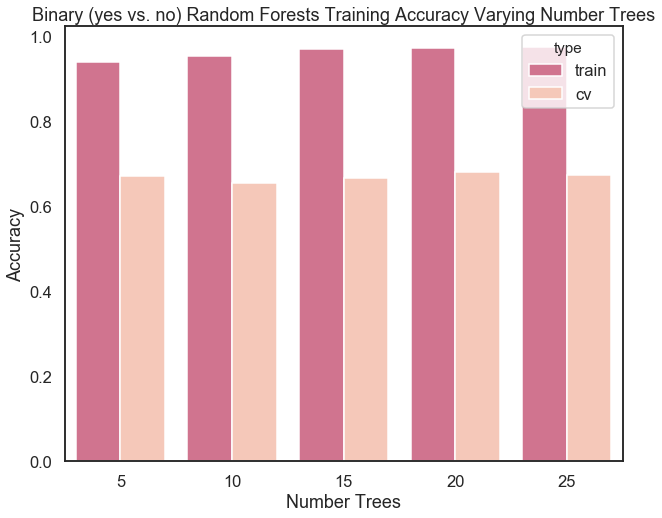

In [50]:
# prepare train df for plotting
accuracy_train_df = pd.DataFrame(accuracy_train_rf.items(), columns = ['n_tree','accuracy'])
accuracy_train_df['type'] = 'train'
accuracy_train_df

# prepare cv df for plotting
accuracy_cv_df = pd.DataFrame(accuracy_cv_rf.items(), columns = ['n_tree','accuracy'])
accuracy_cv_df['type'] = 'cv'

# combine datasets
accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

# generate plot
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'n_tree', y = 'accuracy', hue = 'type', data = accuracy_df,
                palette=['#DF6589', '#FFC3AF'])
ax.set(xlabel='Number Trees',
       ylabel='Accuracy',
       title = 'Binary (yes vs. no) Random Forests Accuracy by Varying Number Trees');

We fit the final model on the training and test datasets.

In [51]:
# fit model
binary_random_forest = ensemble.RandomForestClassifier(n_estimators = 25)
binary_random_forest.fit(X = X_train_binary, y = Y_train_binary)

# obtain accuracies
train_accuracy_rf_binary = binary_random_forest.score(X = X_train_binary, y = Y_train_binary)
test_accuracy_rf_binary  = binary_random_forest.score(X = X_test_binary, y = Y_test_binary)

# print
[train_accuracy_rf_binary, test_accuracy_rf_binary]

[0.9744318181818182, 0.6798866855524079]

### 3c. Predicting Contraceptive of Those Who Use: Short-term vs. Long-term

This is our final round of running models on binary short-term vs. long-term outcome. 

#### i. Feature Selection and Data Preparation

Here are the features we selected for this binary case:

In [52]:
# data preprocessing
contra_train_use = contra_train_clean[contra_train_clean['contraceptive_use'] == 1]
contra_test_use = contra_test_clean[contra_test_clean['contraceptive_use'] == 1]

# training data
X_train_use = contra_train_use.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                     'education_gap', 'wife_education_1', 'wife_work_1', 'wife_age'], axis = 1)
Y_train_use = contra_train_use['contraceptive']

# test data
X_test_use = contra_test_use.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                   'education_gap', 'wife_education_1', 'wife_work_1', 'wife_age'], axis = 1)
Y_test_use = contra_test_use['contraceptive']

####  ii. Logistic Regression

Here is the logistic regression without CV.

In [53]:
# fit model
binary_use_logit = LogisticRegression(solver = 'newton-cg')
binary_use_logit.fit(X = X_train_use, y = Y_train_use)

# obtain accuracies
train_accuracy_lr_use = binary_use_logit.score(X = X_train_use, y = Y_train_use)
test_accuracy_lr_use  = binary_use_logit.score(X = X_test_use, y = Y_test_use)

# print
[train_accuracy_lr_use, test_accuracy_lr_use]

[0.6830065359477124, 0.5911330049261084]

In [54]:
coef_df = pd.DataFrame(np.exp(binary_use_logit.coef_)).T
coef_df.insert(0, 'covariate', X_train_use.columns)
coef_df = coef_df.sort_values(by=0, ascending=False)
coef_df.to_csv('../../3-output/binary-use-logit-coef.csv')
coef_df

,covariate,0
15,est_years_married,1.707865
10,media_exposure_1,1.409701
0,median_marriage_age,1.297509
11,education_gap_categorical_0,1.122332
13,num_child,1.096576
8,standard_living_2,1.084401
7,husband_occupation_4,1.040759
9,standard_living_3,1.036650
4,wife_religion_1,0.697196
14,kids_per_year,0.628148


Here is the logistic regression with CV=10.

In [55]:
# fit model
binary_use_logit_cv = LogisticRegressionCV(cv = 10, solver = 'newton-cg')
binary_use_logit_cv.fit(X = X_train_use, y = Y_train_use)

# obtain accuracies
train_accuracy_cv_use = binary_use_logit_cv.score(X = X_train_use, y = Y_train_use)
test_accuracy_cv_use  = binary_use_logit_cv.score(X = X_test_use, y = Y_test_use)

# print
[train_accuracy_cv_use, test_accuracy_cv_use]

[0.6552287581699346, 0.6551724137931034]

In [56]:
coef_df = pd.DataFrame(np.exp(binary_use_logit_cv.coef_)).T
coef_df.insert(0, 'covariate', X_train_use.columns)
coef_df = coef_df.sort_values(by=0, ascending=False)
coef_df.to_csv('../../3-output/binary-use-logit-cv-coef.csv')
coef_df

,covariate,0
15,est_years_married,1.162491
11,education_gap_categorical_0,1.125818
3,husband_education_4,1.079694
9,standard_living_3,1.053821
7,husband_occupation_4,1.005278
10,media_exposure_1,1.000902
13,num_child,0.995298
8,standard_living_2,0.969562
1,husband_education_2,0.957643
4,wife_religion_1,0.953854


#### iii. Visualize Feature Selection vs. CV Error

Here is how accuracy changes when removing each feature in the first round.

In [57]:
# modified df
contra_df = contra_train_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', \
                               'age_bin_high', 'education_gap'], axis = 1)

# features we will drop one by one
quantitative_features = ['median_marriage_age', 'wife_education_1', 'wife_religion_1', \
                         'wife_work_1', 'media_exposure_1', 'wife_age', 'num_child', \
                         'kids_per_year', 'est_years_married']

# to track accuracy for features
accuracy_train = {}
accuracy_cv_train = {}

# loop through feature removal
for i in range(len(quantitative_features)):

    # The name we are giving to the ith model
    name = quantitative_features[i]

    # subset dataframe
    X_train_i = contra_df.drop(quantitative_features[i], axis = 1)
    Y_train_i = contra_train_clean['contraceptive_use']

    # initialize models
    model = LogisticRegression(solver = 'newton-cg')
    model_cv = LogisticRegressionCV(cv=10, solver='newton-cg')

    # fit models
    model.fit(X = X_train_i, y = Y_train_i)
    model_cv.fit(X = X_train_i, y = Y_train_i)
    train_model = model.score(X = X_train_i, y = Y_train_i)
    train_model_cv = model_cv.score(X = X_train_i, y = Y_train_i)

    # Saving the ith model
    accuracy_train[name] = train_model
    accuracy_cv_train[name] = train_model_cv

[Text(0.5, 1.0, 'Binary Logistic Regression Model Accuracy Removing Each Feature: Short-term vs. Long-term')]

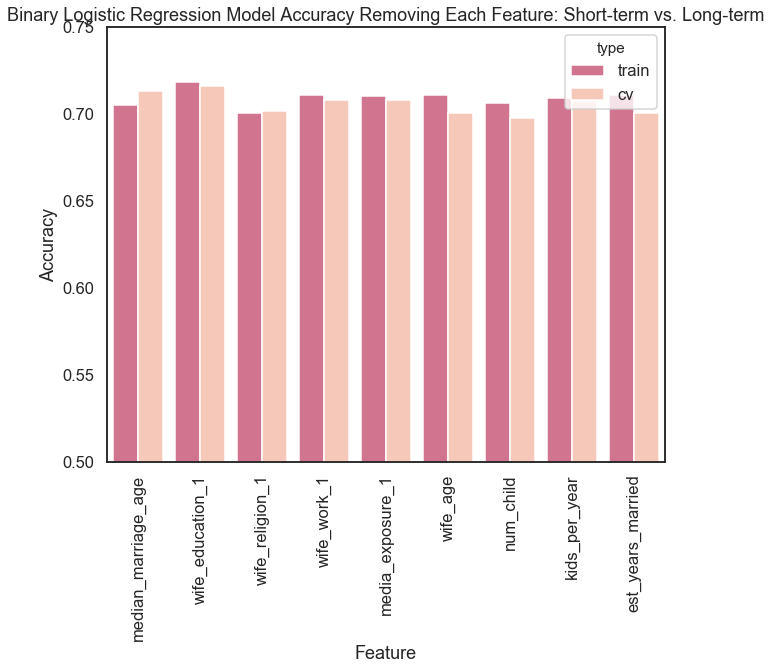

In [58]:
# visualize
ax = visualize_errors(accuracy_train, accuracy_cv_train)
plt.ylim(0.5, 0.75)
ax.set(title = 'Binary Logistic Regression Model Accuracy Removing Each Feature: Short-term vs. Long-term')

#### iv. Random Forests

We cross-validate for number of trees and end up with 15 trees for the final model.

In [59]:
# to track accuracy for features
accuracy_train_rf = {}
accuracy_cv_rf = {}
n_trees = range(5, 30, 5)

# cross validate for n trees
for i in n_trees:
    
    # fit model
    random_forest = ensemble.RandomForestClassifier(n_estimators = i)
    random_forest.fit(X = X_train_use, y = Y_train_use)
    
    # obtain accuracy
    accuracy_train_rf[i] = random_forest.score(X = X_train_use, y = Y_train_use)
    accuracy_cv_rf[i] = cross_val_score(random_forest, X_train_use, Y_train_use, cv = 5).mean()

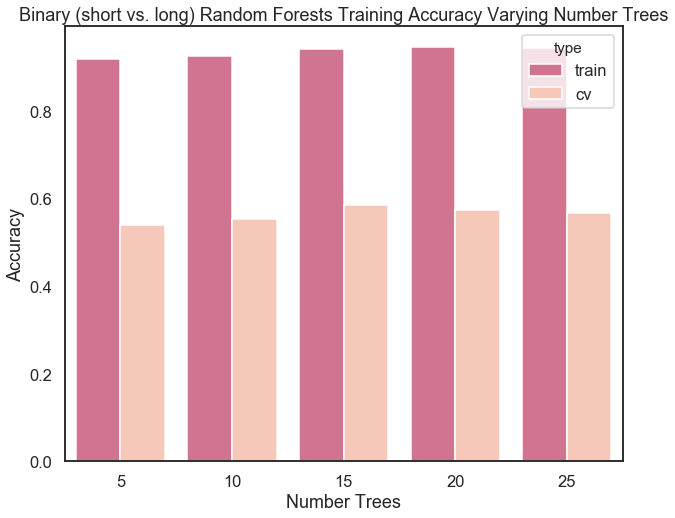

In [60]:
# prepare train df for plotting
accuracy_train_df = pd.DataFrame(accuracy_train_rf.items(), columns = ['n_tree','accuracy'])
accuracy_train_df['type'] = 'train'
accuracy_train_df

# prepare cv df for plotting
accuracy_cv_df = pd.DataFrame(accuracy_cv_rf.items(), columns = ['n_tree','accuracy'])
accuracy_cv_df['type'] = 'cv'

# combine datasets
accuracy_df = pd.concat([accuracy_train_df, accuracy_cv_df])

# generate plot
plt.figure(figsize=(10,8))
ax = sns.barplot(x = 'n_tree', y = 'accuracy', hue = 'type', data = accuracy_df,
                palette=['#DF6589', '#FFC3AF'])
ax.set(xlabel='Number Trees',
       ylabel='Accuracy',
       title = 'Binary (short vs. long) Random Forests Accuracy by Varying Number Trees');

We fit the final RF model to the training and test datasets.

In [61]:
# fit model
binary_use_random_forest = ensemble.RandomForestClassifier(n_estimators = 15)
binary_use_random_forest.fit(X = X_train_use, y = Y_train_use)

# obtain accuracies
train_accuracy_rf_use = binary_use_random_forest.score(X = X_train_use, y = Y_train_use)
test_accuracy_rf_use  = binary_use_random_forest.score(X = X_test_use, y = Y_test_use)

# print
[train_accuracy_rf_use, test_accuracy_rf_use]

[0.9395424836601307, 0.6403940886699507]

## 4. Assessing Precision and Recall
Finally, we want to use apply our predictive models to our test set which was not used anywhere in our predictive modeling process.

### 4a. Multiclass prediction
For the multiclass setting, we examined the medians and standard deviations of the predicted probabilities per each subject. This measure explains how definitive our model was at predicting their classes.

For example, the row `[0.629948, 0.257109, 0.112943]` has a median of 25.71% and standard deviation of 21.78%. Based on the boxplot of medians below, the median is quite small. Based on the boxplot of standard deviations below, a definitive row of predicted probabilities like this has a high standard deviation in comparison to the rest of the predictions. These two pieces of evidence show that our model is predicting probabilities that are quite uniform.

In [62]:
# training data
# remove the first 2 because they are the response
# remove age_bin because they were used for another variable
# remove education_gap because it was coded into a categorical variable
X_train = contra_train_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                             'education_gap', 'wife_age', 'num_child'], axis = 1)
Y_train = contra_train_clean['contraceptive']

# test data
X_test = contra_test_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                           'education_gap', 'wife_age', 'num_child'], axis = 1)
Y_test = contra_test_clean['contraceptive']

In [63]:
probs = multinomial_logit.predict_proba(X_test)
probs_df = pd.DataFrame(probs, columns={0,1,2})
probs_df.head(5)

,0,1,2
0,0.449391,0.435117,0.115492
1,0.392212,0.395012,0.212776
2,0.195485,0.470948,0.333568
3,0.268488,0.316035,0.415477
4,0.256269,0.245607,0.498124


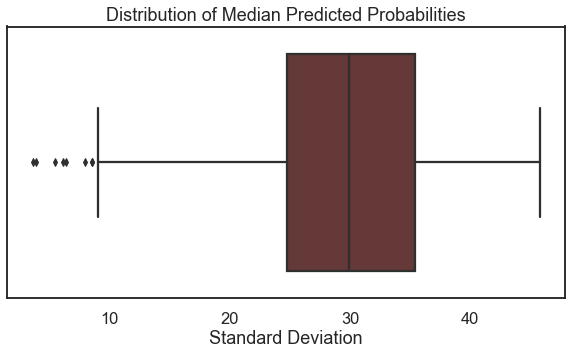

In [64]:
plt.figure(figsize=(10,5))
ax = sns.boxplot((probs_df*100).apply(np.median, axis=1))

ax.set(ylabel='',
       xlabel='Standard Deviation',
       title='Distribution of Median Predicted Probabilities');

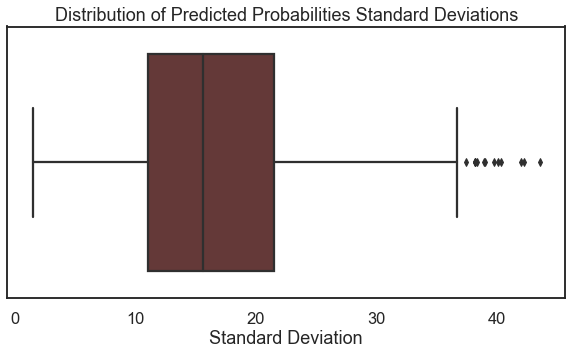

In [65]:
plt.figure(figsize=(10,5))
ax = sns.boxplot((probs_df*100).apply(np.std, axis=1))

ax.set(ylabel='',
       xlabel='Standard Deviation',
       title='Distribution of Predicted Probabilities Standard Deviations');

### 4b. Binary prediction: Use vs. No Use
We calculated the precision and recall for our predictions on our test set.

In [66]:
# training data
X_train_binary = contra_train_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                    'education_gap', 'wife_age'], axis = 1)
Y_train_binary = contra_train_clean['contraceptive_use']

# test data
X_test_binary = contra_test_clean.drop(['contraceptive', 'contraceptive_use', 'age_bin_low', 'age_bin_high', \
                                  'education_gap', 'wife_age'], axis = 1)
Y_test_binary = contra_test_clean['contraceptive_use']

#### Logistic Regression
We had a 67.32% precision rate and a 85.22% recall rate. We also plotted the precision-recall curve for our logistic regression model and a "no skill" predictor which would predict the classification probabilities to be the sample average.

In [67]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# CALCULATE PRECISION AND RECALL VALUES
precision = precision_score(Y_test_binary,
                            binary_logit.predict(X=X_test_binary))

recall = recall_score(Y_test_binary,
                      binary_logit.predict(X=X_test_binary))

print('Precision: %f' % precision)
print('Recall: %f' % recall)

Precision: 0.673152
Recall: 0.852217


In [68]:
from sklearn.metrics import precision_recall_curve

# LF PRECISION/RECALL
lr_probs = binary_logit.predict_proba(X_test_binary)
lr_probs = lr_probs[:, 1]
lr_precision, lr_recall, _ = precision_recall_curve(Y_test_binary, lr_probs)

# PREDICTING AT AVG
no_skill = len(Y_test_binary[Y_test_binary==1]) / len(Y_test_binary)

# CREATE A PLOTTABLE DF
our_df = pd.DataFrame({'recall':lr_recall, 'logistic':lr_precision, 'no_skill':[no_skill]*len(lr_precision)})
our_df = pd.melt(our_df, id_vars='recall')

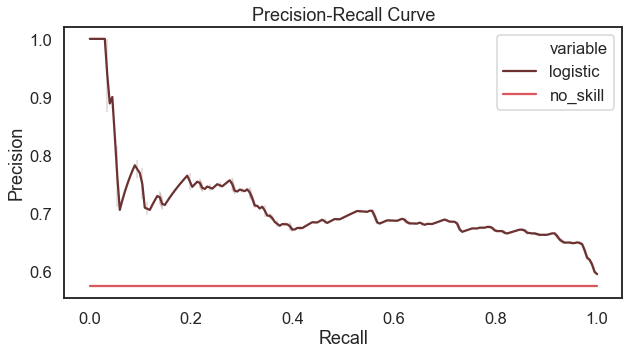

In [69]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='recall',
                  y='value',
                  hue='variable',
                  data=our_df)

ax.set(ylabel='Precision',
       xlabel='Recall',
       title='Precision-Recall Curve');

#### Random Forest
We had a 70.80% precision rate and a 78.82% recall rate. We also plotted the precision-recall curve for our logistic regression model and a "no skill" predictor which would predict the classification probabilities to be the sample average.

In [70]:
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

# CALCULATE PRECISION AND RECALL VALUES
precision = precision_score(Y_test_binary,
                            binary_random_forest.predict(X=X_test_binary))

recall = recall_score(Y_test_binary,
                      binary_random_forest.predict(X=X_test_binary))

print('Precision: %f' % precision)
print('Recall: %f' % recall)

Precision: 0.702703
Recall: 0.768473


In [71]:
# RF PRECISION/RECALL
rf_probs = binary_random_forest.predict_proba(X_test_binary)
rf_probs = rf_probs[:, 1]
rf_precision, rf_recall, _ = precision_recall_curve(Y_test_binary, rf_probs)

# PREDICTING AT AVG
no_skill = len(Y_test_binary[Y_test_binary==1]) / len(Y_test_binary)

# CREATE A PLOTTABLE DF
our_df = pd.DataFrame({'recall':rf_recall, 'random forest':rf_precision, 'no_skill':[no_skill]*len(rf_precision)})
our_df = pd.melt(our_df, id_vars='recall')

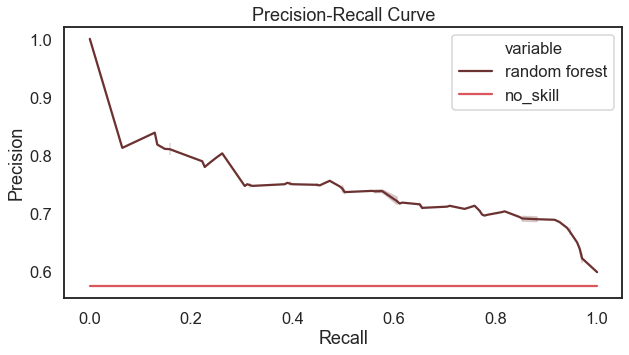

In [72]:
plt.figure(figsize=(10,5))
ax = sns.lineplot(x='recall',
                  y='value',
                  hue='variable',
                  data=our_df)

ax.set(ylabel='Precision',
       xlabel='Recall',
       title='Precision-Recall Curve');